# Rethinking Statistics course in Numpyro - Week 5

Lecture 9: Conditional Manatees

- [Video](https://www.youtube.com/watch?v=QhHfo6-Bx8o)
- [Slides](https://speakerdeck.com/rmcelreath/l09-statistical-rethinking-winter-2019)

Lecture 10: Markov Chain Monte Carlo

- [Video](https://youtu.be/v-j0UmWf3Us)
- [Slides](https://speakerdeck.com/rmcelreath/l10-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week05.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week05_solutions.pdf) for the exercises of the week.

In [1]:
import numpy as np
import pandas as pd

from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive

import arviz as az
import seaborn as sns

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Apr 17 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.21.0

numpyro: 0.6.0
arviz  : 0.11.2
numpy  : 1.20.1
seaborn: 0.11.1
pandas : 1.2.3
jax    : 0.2.10

Watermark: 2.2.0



In [3]:
sns.set_style('whitegrid')
rng_key = random.PRNGKey(0)

## Exercise 1

> Consider the data (`Wines2012`) data table. These data are expert ratings of 20 different French and American wines by 9 different French and American judges. Your goal is to model score, the subjective rating assigned by each judge to each wine. I recommend standardizing it.

> In this first problem, consider only variation among judges and wines. Construct index variables of judge and wine and then use these index variables to construct a linear regression model. Justify your priors. You should end up with 9 judge parameters and 20 wine parameters. Use `ulam` instead of `quap` to build this model, and be sure to check the chains for convergence. If you'd rather build the model directly in `Stan` or `PyMC3` or `NumPyro`, go ahead. I just want you to use Hamiltonian Monte Carlo instead of quadratic approximation.

> How do you interpret the variation among individual judges and individual wines? Do you notice any patterns, just by plotting the differences? Which judges gave the highest/lowest ratings? Which wines were rated worst/best on average?

Let's get the data.

In [4]:
d = pd.read_csv('./dat/Wines2012.csv', header=0, sep=';')
d.tail(3)

,judge,flight,wine,score,wine.amer,judge.amer
177,Francis Schott,red,H2,16.0,1,1
178,Francis Schott,red,I2,7.0,1,1
179,Francis Schott,red,J2,17.0,0,1


In [5]:
d.score = (d.score - d.score.mean())/d.score.std()
for feat in ['judge', 'flight', 'wine']:
    d[feat] = d[feat].astype('category').cat.codes
d = d.rename(columns = {'wine.amer':'win_usa', 'judge.amer':'jdg_usa'})
d.tail(3)

,judge,flight,wine,score,win_usa,jdg_usa
177,1,0,15,0.675687,1,1
178,1,0,17,-2.702750,1,1
179,1,0,19,1.051069,0,1


The model is straightforward. The only issue is the priors. Since I've standardized the outcome, we can use the ordinary $N(0,0.5)$ prior from the examples in the text with standardized outcomes. Then the prior outcomes will stay largely within the possible outcome space. A bit more regularization than that wouldn't be a bad idea either.

In [6]:
def model(judge, wine, score=None):
    # priors
    nj, nw = len(np.unique(judge)), len(np.unique(wine))
    a = numpyro.sample('a', dist.Normal(0,0.5), sample_shape=(nj,))
    w = numpyro.sample('w', dist.Normal(0,0.5), sample_shape=(nw,))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = a[judge] + w[wine]
    numpyro.sample('score_hat', dist.Normal(mu,sigma), obs=score)

In [7]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, judge=d.judge.values, wine=d.wine.values, score=d.score.values)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:01<00:00, 571.08it/s, 7 steps of size 5.39e-01. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.28      0.20     -0.28     -0.63      0.04   1664.08      1.00
      a[1]      0.22      0.19      0.22     -0.10      0.53   1473.14      1.00
      a[2]      0.20      0.21      0.20     -0.13      0.54   1648.35      1.00
      a[3]     -0.54      0.20     -0.55     -0.88     -0.23   1591.42      1.00
      a[4]      0.80      0.20      0.79      0.48      1.11   1585.20      1.00
      a[5]      0.48      0.19      0.48      0.17      0.81   1388.21      1.00
      a[6]      0.13      0.19      0.13     -0.18      0.43   1254.71      1.00
      a[7]     -0.66      0.19     -0.66     -0.97     -0.33   1556.47      1.00
      a[8]     -0.35      0.19     -0.35     -0.66     -0.02   1649.69      1.00
     sigma      0.85      0.05      0.85      0.77      0.91   2569.60      1.00
      w[0]      0.12      0.26      0.12     -0.29      0.54   1965.27      1.00
      w[1]      0.09      0

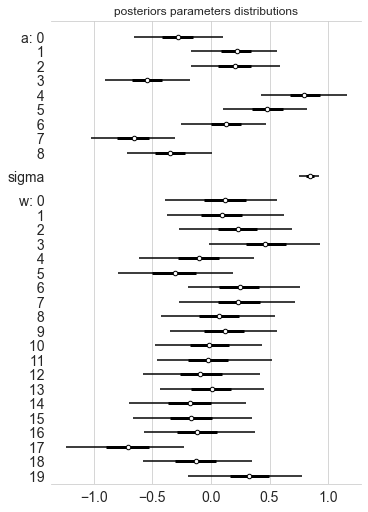

In [8]:
samples = az.from_numpyro(mcmc)
axes = az.plot_forest(samples,
                      kind='forestplot',
                      combined=True,
                      ridgeplot_overlap=1,
                      colors='black',
                      figsize=(5, 7))
axes[0].set_title('posteriors parameters distributions');

The `a` parameters are the judges. Each represents an average deviation of the scores. So judges with lower values are harsher on average. Judges with higher values liked the wines more on average. There is some noticeable variation here. It is fairly easy to tell the judges apart. The `w` parameters are the wines. Each represents an average score across all judges. Except for wine 18 (a New Jersey red I think), there isn't that much variation. These are good wines, after all. Overall, there is more variation from judge than from wine.

Index starts at zero in python so all references from now on in the original text to specific parameters or individuals, such as wine 18 in the previous text refer to one integer less in the results in `numpyro`. So in this case wine 18 is actually wine 17, because there is a wine 0. It's pretty clear just having a look at the foresplot but we better keep that in mind because in other occasions this may be a cause for confusion.

## Exercise 2

> Now consider three features of the wines and judges:

> 1. `flight`: Whether the wine is red or white.
2. `win_usa`: Indicator variable for American wines.
3. `jdg_usa`: Indicator variable for American judges.

> Use indicator or index variables to model the influence of these features on the scores. Omit the individual judge and wine index variables from Problem (1) Do not include interaction effects yet. Again use `ulam`, justify your priors, and be sure to check the chains. What do you conclude about the differences among the wines and judges? Try to relate the results to the inferences in Problem (1).

By "indicator" he means using a unique coefficient per variable. By "index" he means what in Machine Learning we just call one-hot-encoding variables. We divide each categorical variable in as many variables as categories with ones and zeros so we end up with many more variables and parameters.

### Indicator variables version

The easiest way to code the data is to use indicator variables. Let's look at that approach first. I'll do an index variable version next. I'll use the three indicator variables `W` (NJ wine), `J` (American NJ), and `R` (red wine).

The model structure is just a linear model with an ordinary intercept. I'll put a relatively tight prior on the intercept, since it must be near zero (centered outcome). What about the coefficients for the indicator variables? Let's pretend we haven't already seen the results from Problem 1, there aren't any big wine differences to find there. Without that cheating foresight, we should consider what the most extreme effect could be. How big could the difference between NJ and French wines be? Could it be a full standard deviation? If so, then maybe a Normal(0,0.5) prior makes sense, since they place a full standard deviation difference out in the tails of the prior. I'd personally be inclined to something even tighter, so that it regularizes more. But let's go with these wide priors, which nevertheless stay within the outcome space. It would make even more sense to put a tighter prior on the difference between red and white wines, on average they should be the no different, because judges only compare within flights. Here's the model:

In [9]:
def model(jdg_usa, win_usa, flight, score=None):
    # priors
    a = numpyro.sample('a', dist.Normal(0, 0.2))
    bW = numpyro.sample('bW', dist.Normal(0, 0.5))
    bJ = numpyro.sample('bJ', dist.Normal(0, 0.5))
    bR = numpyro.sample('bR', dist.Normal(0, 0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = a + bW*win_usa + bJ*jdg_usa + bR*flight
    numpyro.sample('score_hat', dist.Normal(mu,sigma), obs=score)

In [10]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
dat = {k:v.to_numpy() for k,v in d[['jdg_usa','win_usa','flight','score']].items()}
mcmc.run(rng_key, **dat)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:01<00:00, 531.26it/s, 15 steps of size 4.66e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.02      0.13     -0.02     -0.22      0.18   1189.84      1.00
        bJ      0.23      0.14      0.23     -0.00      0.45   1312.44      1.00
        bR      0.00      0.14     -0.00     -0.24      0.22   1671.12      1.00
        bW     -0.18      0.14     -0.18     -0.43      0.03   1592.51      1.00
     sigma      0.99      0.05      0.99      0.90      1.07   1960.80      1.00

Number of divergences: 0


As expected, red and wines are on average the same. `bR` is right on top of zero. American judges seem to be more on average slightly more generous with ratings, `bJ` is slightly but reliably above zero. American wines have slightly lower average ratings than French wines, `bW` is mostly below zero, but not very large in absolute size.

### Index variables version

Okay, now for an index variable version. The thing about index variables is that you can easily end up with more parameters than in an equivalent indicator variable model. But it's still the same posterior distribution. You can convert from one to the other, if the priors are also equivalent. We'll need three index variables.

In [11]:
def model(jdg_usa, win_usa, flight, score = None):
    # indices
    nJ, nW, nR = len(np.unique(jdg_usa)), len(np.unique(win_usa)), len(np.unique(flight))
    # priors
    w = numpyro.sample('w', dist.Normal(0,0.5), sample_shape=(nW,))
    j = numpyro.sample('j', dist.Normal(0,0.5), sample_shape=(nJ,))
    r = numpyro.sample('r', dist.Normal(0,0.5), sample_shape=(nR,))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = w[win_usa] + j[jdg_usa] + r[flight]
    numpyro.sample('score_hat', dist.Normal(mu,sigma), obs=score)

In [12]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
dat = {k:v.to_numpy() for k,v in d[['jdg_usa','win_usa','flight','score']].items()}
mcmc.run(rng_key, **dat)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:01<00:00, 516.15it/s, 7 steps of size 2.21e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      j[0]     -0.12      0.30     -0.11     -0.62      0.36    761.21      1.01
      j[1]      0.12      0.30      0.12     -0.36      0.64    780.23      1.01
      r[0]     -0.02      0.30     -0.02     -0.47      0.52    651.82      1.01
      r[1]     -0.01      0.30     -0.01     -0.50      0.50    618.52      1.01
     sigma      1.00      0.06      1.00      0.92      1.10   1139.54      1.00
      w[0]      0.11      0.32      0.10     -0.37      0.66    804.37      1.00
      w[1]     -0.08      0.32     -0.08     -0.56      0.47    829.40      1.00

Number of divergences: 0


To see that this model is the same as the previous, let's compute contrasts. The contrast between American and French wines is:

In [13]:
dat.pop('score')
prior = Predictive(model, num_samples=500)(rng_key,**dat)
posterior = mcmc.get_samples()
diff_w = posterior['w'].T[1] - posterior['w'].T[0]
print(f'mu={diff_w.mean():.2f}, std={diff_w.std():.2f}')

mu=-0.19, std=0.15


That's almost exactly the same mean and standard deviation as `bW` in the first model. The other contrasts match as well. Something to notice about the two models is that the second one does sample less efficiently. The `n_eff` (`ess_mean` in ArviZ) values are lower. This isn't a problem, but it is a consequence of the higher correlations in the posterior, a result of the redundant parameterization. This is because really it is a difference that matters, and many combinations of two numbers can produce the same difference. But the priors keep this from ruining our inference. If you tried the same thing without priors, it would likely fall apart and return very large standard errors.

## Exercise 3

> Now consider two-way interactions among the three features. You should end up with three different interaction terms in your model. These will be easier to build, if you use indicator variables. Again use `ulam` (`Numpyro!`), justify your priors, and be sure to check the chains. Explain what each interaction means. Be sure to interpret the model's predictions on the outcome scale (mu, the expected score), not on the scale of individual parameters. You can use link to help with this, or just use your knowledge of the linear model instead.

> What do you conclude about the features and the scores? Can you relate the results of your model(s) to the individual judge and wine inferences from Exercise 1?


### Indicator variables version

I used the same priors as before for the main effects. I used tighter priors for the interactions. Why? Because interactions represent sub-categories of data, and if we keep slicing up the sample, differences can't keep getting bigger. Again, the most important thing is not to use flat priors like Normal(0,10) that produce impossible outcomes.

In [14]:
def model(jdg_usa, win_usa, flight, score=None):
    # priors
    a = numpyro.sample('a', dist.Normal(0,0.2))
    bW = numpyro.sample('bW', dist.Normal(0,0.5))
    bJ = numpyro.sample('bJ', dist.Normal(0,0.5))
    bR = numpyro.sample('bR', dist.Normal(0,0.5))
    bWJ = numpyro.sample('bWJ', dist.Normal(0,0.25))
    bWF = numpyro.sample('bWR', dist.Normal(0,0.25))
    bJF = numpyro.sample('bJR', dist.Normal(0,0.25))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = a + bW*win_usa + bJ*jdg_usa + bR*flight + bWJ*win_usa*jdg_usa + bWF*win_usa*flight + bJF*jdg_usa*flight
    numpyro.sample('score_hat', dist.Normal(mu,sigma), obs=score)

In [15]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
dat = {k:v.to_numpy() for k,v in d[['jdg_usa','win_usa','flight','score']].items()}
mcmc.run(rng_key, **dat)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 452.00it/s, 15 steps of size 3.39e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.01      0.12      0.01     -0.20      0.21   1348.44      1.00
        bJ      0.25      0.17      0.25     -0.03      0.53   1515.19      1.00
       bJR      0.00      0.18      0.00     -0.29      0.30   1847.36      1.00
        bR     -0.11      0.18     -0.10     -0.41      0.18   1414.85      1.00
        bW     -0.24      0.17     -0.25     -0.51      0.05   1752.28      1.00
       bWJ     -0.04      0.18     -0.04     -0.35      0.23   1820.28      1.00
       bWR      0.20      0.19      0.20     -0.11      0.50   1566.29      1.00
     sigma      0.99      0.05      0.99      0.91      1.09   1637.30      1.00

Number of divergences: 0


Reading the parameters this way is not easy. But right away you might notice that `bW` is now close to zero and overlaps it a lot on both sides. NJ wines are no longer on average worse. So the interactions did something. Glancing at the interaction parameters, you can see that only one of them has much mass away from zero, `bWR`, the interaction between NJ wines and red flight, so red NJ wines.

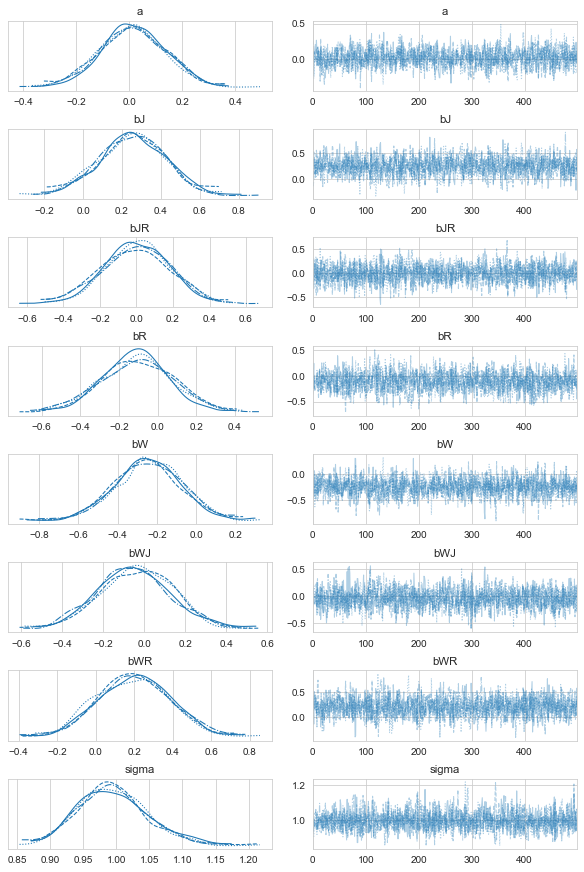

In [16]:
dat.pop('score')
posterior = mcmc.get_samples()
posterior_pred = Predictive(model, posterior)(rng_key, **dat)
samples_31 = az.from_numpyro(mcmc, posterior_predictive=posterior_pred)
az.plot_trace(samples_31, figsize=(8,12));

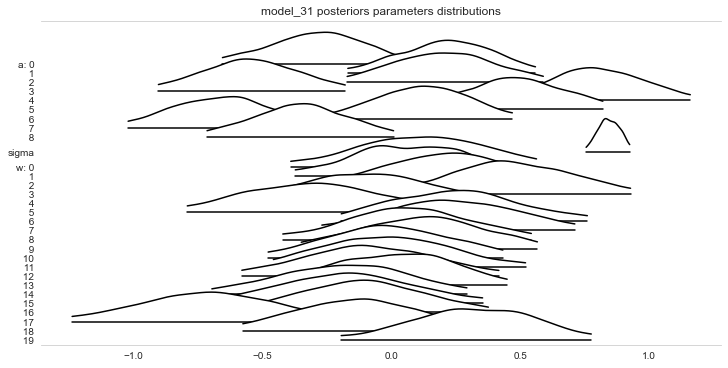

In [17]:
axes = az.plot_forest(samples,
                      kind='ridgeplot',
                      combined=True,
                      ridgeplot_overlap=3,
                      colors='white',
                      figsize=(10, 5))
axes[0].set_title('model_31 posteriors parameters distributions');

### Index variables version

Now let's do an index version. The way to think of this is to make unique parameters for each combination. If we consider all the interactions, including a three-way interaction between nation, judge and flight, there would be 8 combinations and so 8 parameters to estimate. Let's go ahead and do that, so we can simultaneously consider the 3-way interaction.

In [18]:
def model(jdg_usa, win_usa, flight, score = None):
    # indices
    ixJ, ixW, ixR = jdg_usa, win_usa, flight
    nJ, nW, nR = len(np.unique(ixJ)), len(np.unique(ixW)), len(np.unique(ixR))
    # priors
    w = numpyro.sample('w', dist.Normal(0,0.5), sample_shape=(nW,))
    j = numpyro.sample('j', dist.Normal(0,0.5), sample_shape=(nJ,))
    f = numpyro.sample('f', dist.Normal(0,0.5), sample_shape=(nR,))
    wj = numpyro.sample('wj', dist.Normal(0,0.5), sample_shape=(nW*nJ,))
    wf = numpyro.sample('wf', dist.Normal(0,0.5), sample_shape=(nW*nR,))
    jf = numpyro.sample('jf', dist.Normal(0,0.5), sample_shape=(nJ*nR,))
    wjf = numpyro.sample('wjf', dist.Normal(0,0.5), sample_shape=(nW*nJ*nR,))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = w[ixW] + j[ixJ] + f[ixR] + wj[ixW*ixJ] + wf[ixW*ixR] + jf[ixJ*ixR] + wjf[ixW*ixJ*ixR] 
    numpyro.sample('score_hat', dist.Normal(mu,sigma), obs=score)

In [19]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
dat = {k:v.to_numpy() for k,v in d[['jdg_usa','win_usa','flight','score']].items()}
mcmc.run(rng_key, **dat)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:03<00:00, 298.34it/s, 31 steps of size 1.03e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      0.15      0.35      0.14     -0.40      0.74   1489.43      1.00
      f[1]     -0.14      0.34     -0.14     -0.66      0.46   1533.34      1.00
      j[0]     -0.11      0.34     -0.11     -0.70      0.44   1517.48      1.00
      j[1]      0.15      0.34      0.16     -0.41      0.70   1492.33      1.00
     jf[0]     -0.06      0.36     -0.06     -0.63      0.54   1423.96      1.00
     jf[1]      0.05      0.36      0.06     -0.55      0.60   1381.08      1.00
     jf[2]     -0.01      0.51     -0.01     -0.84      0.84   2096.38      1.00
     jf[3]      0.00      0.49      0.02     -0.82      0.74   2213.79      1.00
     sigma      0.99      0.05      0.99      0.91      1.08   1939.86      1.00
      w[0]      0.20      0.36      0.20     -0.34      0.82   1235.10      1.00
      w[1]     -0.18      0.34     -0.18     -0.71      0.41   1221.28      1.00
     wf[0]     -0.27      0

In [20]:
dat.pop('score')
posterior = mcmc.get_samples()
posterior_pred = Predictive(model, posterior)(rng_key, **dat)
samples_32 = az.from_numpyro(mcmc, posterior_predictive=posterior_pred)

Models predictions and comparison:

In [21]:
pp_31 = samples_31.posterior_predictive.score_hat.values
pp_32 = samples_32.posterior_predictive.score_hat.values
d = d.assign(score_hat_32=pp_32.mean(axis=1).mean(axis=0),
             score_hat_31=pp_31.mean(axis=1).mean(axis=0))
aux = d.groupby(['win_usa', 'jdg_usa','flight'])[['score','score_hat_31','score_hat_32']].mean().reset_index()
combinations = ['FFW', 'FFR', 'FAW', 'FAR', 'AFW', 'AFR', 'AAW', 'AAR'] # wine, judge, flight order
aux['combination'] = combinations
aux = round(aux[['combination', 'score','score_hat_31', 'score_hat_32']],2)
aux

,combination,score,score_hat_31,score_hat_32
0,FFW,0.25,0.01,0.07
1,FFR,-0.38,-0.10,-0.23
2,FAW,0.32,0.26,0.33
3,FAR,0.20,0.16,0.16
4,AFW,-0.42,-0.23,-0.31
5,AFR,0.04,-0.12,-0.02
6,AAW,-0.02,-0.02,-0.04
7,AAR,0.04,0.08,0.07


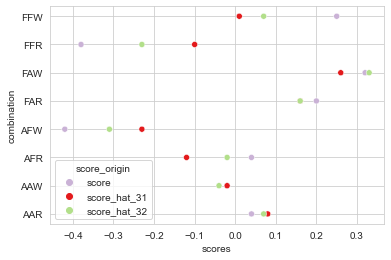

In [22]:
aux_plot = aux.melt(id_vars='combination',
                    value_vars=['score','score_hat_31','score_hat_32'],
                    var_name='score_origin',
                    value_name='scores')

g = sns.scatterplot(data=aux_plot, x='scores', y='combination', hue='score_origin', palette='Paired_r')

`score` is just the average for that category, `score_hat_31` is the posterior predictive for the Indicator version and `score_hat_32` for the index version.

I've added informative labels. FFW means: French wine, French judge, White wine. The two rows that jump out are the 4th and the (_6th_), AFR and FAR. Those are NJ red wines as judged by French judges and French red wines as judged by American judges. French judges didn't like NJ reds so much (really only one NJ red, if you look back at Exercise 1). And American judges liked French reds more. Besides these two interactions, notice that it is very hard to figure this out from the table of coefficients.

The most noticeable change when comparing models is that FFW (French wines, French judges, white) have a lower expected rating in the full interaction model. There are some other minor differences as well. What has happened? The three way interaction would be, in the first model's indicator terms, when a wine is American, the judge is American, and the flight is red. In the first model, a prediction for such a wine is just a sum of parameters:

$\mu_{i} = \alpha + \beta_{W} + \beta_{J} + \beta_{R} + \beta_{WJ} + \beta_{WR} + \beta_{JR}$

This of course limits means that these parameters have to account for the AAR wine. In the full interaction mode, an AAR wine gets its own parameter, as does every other combination. None of the parameters get polluted by averaging over different combinations. Of course, there isn't a lot of evidence that prediction is improved much by allowing this extra parameter. The differences are small, overall. These wines are all quite good. But it is worth understand how the full interaction model gains additional flexibility. This additional flexibility typically requires some addition regularization. When we arrive at multilevel models later, you'll see how we can handle regularization more naturally inside of a model.